In [149]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse.csgraph import connected_components
from time import time

In [142]:
def plot_dungeon(A, B, square_density=1):
    m, n = A.shape[0], B.shape[1]
    def _indices(A):
        m, n = A.shape
        x_indices = np.ravel([[i]*n for i in range(m)])
        y_indices = np.ravel(list(range(n))*m)
        return zip(x_indices, y_indices)

    plt.figure(figsize=(10*n/(m+n), 10*m/(m+n)))
    def vertical_plot(walls):
        m, n = walls.shape
        for i, j in _indices(walls):
            if walls[i, j] == 1:
                plt.vlines((j+1)/(n+1), 1-i/(m), 1-(i+1)/(m))

    def horizontal_plot(walls):
        m, n = walls.shape
        for i, j in _indices(walls):
            if walls[i, j] == 1:
                plt.hlines(1-(i+1)/(m+1), j/(n), (j+1)/(n))

    vertical_plot(A)
    horizontal_plot(B)

    plt.vlines([0, 1], [0, 0], [1, 1])
    plt.hlines([0, 1], [0, 0], [1, 1])
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.yticks(np.linspace(0, 1, square_density * m + 1))
    plt.xticks(np.linspace(0, 1, square_density * n + 1))
    plt.grid()
    plt.tick_params(axis='both', left=False, bottom=False, labelleft=False, labelbottom=False)
    plt.show()

def random_dungeon(m, n, p_wall=0.4, max_connected_components=None):
    def _adjacency(A, B):
        m, n = A.shape[0], B.shape[1]
        C = np.zeros((m*n, m*n))

        def _get_i_j(ind):
            i = ind // m
            j = ind % m
            return i, j

        def _get_ind(i, j):
            return i*m + j

        for ind in range(m*n):
            i, j = _get_i_j(ind)
            if i != 0: # look up
                if B[i-1, j] == 0:
                    C[ind, _get_ind(i-1, j)] = 1
            if i != m-1: # look down
                if B[i, j] == 0:
                    C[ind, _get_ind(i+1, j)] = 1
            if j != 0: # look left
                if A[i, j-1] == 0:
                    C[ind, _get_ind(i, j-1)] = 1
            if j != n-1: # look right
                if A[i, j] == 0:
                    C[ind, _get_ind(i, j+1)] = 1

        return C
    
    A = np.random.choice(2, size=(m, n-1), p=[1-p_wall, p_wall])
    B = np.random.choice(2, size=(m-1, n), p=[1-p_wall, p_wall])
    C = _adjacency(A, B)
    
    if connected_components is not None:
        while connected_components(C)[0] > max_connected_components:
            A = np.random.choice(2, size=(m, n-1), p=[1-p_wall, p_wall])
            B = np.random.choice(2, size=(m-1, n), p=[1-p_wall, p_wall])
            C = _adjacency(A, B)
    
    return A, B, C

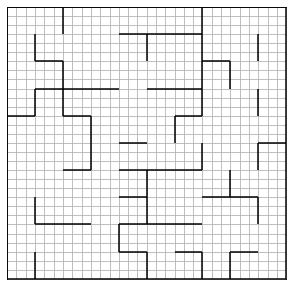

0.25591492652893066


In [148]:
start = time()
A, B, C = random_dungeon(10, 10, p_wall=0.3, max_connected_components=1)
plot_dungeon(A, B, square_density=3)
connected_components(C)
print(time() - start)

In [178]:
monster_df = pd.read_csv('dnd_monsters.csv', index_col=0)
monster_df.tail()

,url,cr,type,size,ac,hp,speed,align,legendary,source,str,dex,con,int,wis,cha
name,,,,,,,,,,,,,,,,
yuan-ti-pureblood,https://www.aidedd.org/dnd/monstres.php?vo=yua...,1,humanoid (yuan-ti),Medium,11,40,NaN,neutral evil,NaN,Monster Manual (BR),11.0,12.0,11.0,13.0,12.0,14.0
zaratan,NaN,22,elemental,Gargantuan,21,307,swim,neutral,NaN,Mordenkainen's Tome of Foes,NaN,NaN,NaN,NaN,NaN,NaN
zariel,https://www.aidedd.org/dnd/monstres.php?vo=zariel,26,fiend (devil),Large,21,580,fly,lawful evil,Legendary,Mordenkainen's Tome of Foes,27.0,24.0,28.0,26.0,27.0,30.0
zombie,https://www.aidedd.org/dnd/monstres.php?vo=zombie,1/4,undead,Medium,8,22,NaN,neutral evil,NaN,Monster Manual (SRD),13.0,6.0,16.0,3.0,6.0,5.0
zuggtmoy,NaN,23,fiend (demon),Large,18,304,NaN,chaotic evil,NaN,Mordenkainen's Tome of Foes,NaN,NaN,NaN,NaN,NaN,NaN


In [189]:
monsters = {'aarakocra': 3, 'yuan-ti-pureblood': 4}
party = {6: 3, 3: 1}

In [190]:
monster_df = pd.read_csv('dnd_monsters.csv', index_col=0)
player_df = pd.read_csv('dnd_player_exp', index_col=0)

cr_to_xp = {
    '0': 0,
    '1/8': 25,
    '1/4': 50,
    '1/2': 100,
    '1': 200,
    '2': 450,
    '3': 700,
    '4': 1100,
    '5': 1800,
    '6': 2300,
    '7': 2900,
    '8': 3900,
    '9': 5000,
    '10': 5900,
    '11': 7200,
    '12': 8400,
    '13': 10000,
    '14': 11500,
    '15': 13000,
    '16': 15000,
    '17': 18000,
    '18': 20000,
    '19': 22000,
    '20': 25000,
    '21': 33000,
    '22': 41000,
    '23': 50000,
    '24': 62000,
    '25': 75000,
    '26': 90000,
    '27': 105000,
    '28': 120000,
    '29': 135000,
    '30': 155000
}

def _quantity_multiplier(n):
    if n <= 1:
        return 1
    elif n <= 2: 
        return 1.5
    elif n <= 6:
        return 2
    elif n <= 10:
        return 2.5
    elif n <= 14:
        return 3
    else:
        return 4

def _monsters_xp(monsters):
    xp = 0
    total_monsters = 0
    for monster in monsters:
        monster_xp = cr_to_xp[monster_df.loc[monster]['cr']]
        xp += monsters[monster] * monster_xp
        total_monsters += monsters[monster]
        
    return _quantity_multiplier(total_monsters) * xp
    
def _party_xp(party, difficulty):
    xp = 0
    for level in party:
        xp += party[level] * player_df.loc[level][difficulty]
        
    return xp

def _encounter_difficulty(party, monsters):
    mxp = _monsters_xp(monsters)
    print(mxp)
    if mxp < _party_xp(party, 'Easy'):
        return 'Trivial'
    elif mxp < _party_xp(party, 'Medium'):
        return 'Easy'
    elif mxp < _party_xp(party, 'Hard'):
        return 'Medium'
    elif mxp < _party_xp(party, 'Deadly'):
        return 'Hard'
    else:
        return 'Deadly'

In [191]:
_encounter_difficulty(party, monsters)

2375.0


'Medium'

In [164]:
player_np = np.array([
    [25, 50, 75, 100],
    [50, 100, 150, 200],
    [75, 150, 225, 400],
    [125, 250, 375, 500],
    [250, 500, 750, 1100],
    [300, 600, 900, 1400],
    [350, 750, 1100, 1700],
    [450, 900, 1400, 2100],
    [550, 1100, 1600, 2400],
    [600, 1200, 1900, 2800],
    [800, 1600, 2400, 3600],
    [1000, 2000, 3000, 4500],
    [1100, 2200, 3400, 5100],
    [1250, 2500, 3800, 5700],
    [1400, 2800, 4300, 6400],
    [1600, 3200, 4800, 7200],
    [2000, 3900, 5900, 8800],
    [2100, 4200, 6300, 9500],
    [2400, 4900, 7300, 10900],
    [2800, 5700, 8500, 12700]
])

In [170]:
player_df = pd.DataFrame(data=player_np, columns=['Easy', 'Medium', 'Hard', 'Deadly'])
player_df['Player Level'] = range(1, 21)
player_df.set_index('Player Level', inplace=True)
player_df.head()

,Easy,Medium,Hard,Deadly
Player Level,,,,
1,25,50,75,100
2,50,100,150,200
3,75,150,225,400
4,125,250,375,500
5,250,500,750,1100


In [173]:
player_df = pd.read_csv('dnd_player_exp', index_col=0)
player_df.head()

,Easy,Medium,Hard,Deadly
Player Level,,,,
1,25,50,75,100
2,50,100,150,200
3,75,150,225,400
4,125,250,375,500
5,250,500,750,1100
